<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/CNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_2015_data_colored_resized_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-2015-data-colored-resized')

print('Data source import complete.')


In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-2015-data-colored-resized/trainLabels.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['level'].map(diagnosis_dict_binary.get)
df['type'] = df['level'].map(diagnosis_dict.get)
df.head()

,image,level,binary_type,type
0,10_left,0,No_DR,No_DR
1,10_right,0,No_DR,No_DR
2,13_left,0,No_DR,No_DR
3,13_right,0,No_DR,No_DR
4,15_left,1,DR,Mild


<AxesSubplot:>

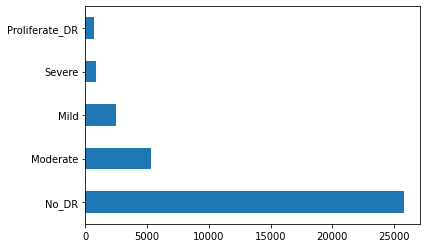

In [ ]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

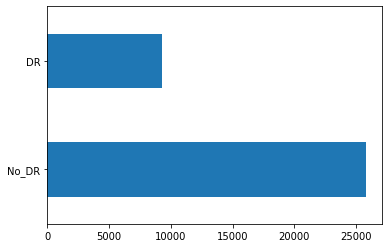

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             18067
Moderate           3704
Mild               1710
Severe              611
Proliferate_DR      496
Name: type, dtype: int64 

No_DR             3871
Moderate           794
Mild               367
Severe             131
Proliferate_DR     106
Name: type, dtype: int64 

No_DR             3872
Moderate           794
Mild               366
Severe             131
Proliferate_DR     106
Name: type, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [ ]:
# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 24588 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.


In [ ]:
# # Building the model

import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), padding="valid", input_shape=(224,224,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, (3,3), padding="valid", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(128, (3,3), padding="valid", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(256, (3,3), padding="valid", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

# 編譯
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 訓練
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=val_batches)

# model = tf.keras.Sequential([
#     layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.BatchNormalization(),

#     layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.BatchNormalization(),

#     layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.BatchNormalization(),

#     layers.Flatten(),
#     layers.Dense(32, activation = 'relu'),
#     layers.Dropout(0.15),
#     layers.Dense(2, activation = 'softmax')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['acc'])

# history = model.fit(train_batches,
#                     epochs=10,
#                     validation_data=val_batches)

Epoch 1/10
769/769 [==============================] - 74s 85ms/step - loss: 0.6225 - accuracy: 0.7266 - val_loss: 0.5712 - val_accuracy: 0.7349
Epoch 2/10
769/769 [==============================] - 60s 78ms/step - loss: 0.5777 - accuracy: 0.7341 - val_loss: 0.5632 - val_accuracy: 0.7347
Epoch 3/10
769/769 [==============================] - 59s 77ms/step - loss: 0.5733 - accuracy: 0.7347 - val_loss: 0.5575 - val_accuracy: 0.7349
Epoch 4/10
769/769 [==============================] - 60s 78ms/step - loss: 0.5686 - accuracy: 0.7343 - val_loss: 0.5503 - val_accuracy: 0.7349
Epoch 5/10
769/769 [==============================] - 64s 83ms/step - loss: 0.5597 - accuracy: 0.7348 - val_loss: 0.5553 - val_accuracy: 0.7349
Epoch 6/10
769/769 [==============================] - 63s 82ms/step - loss: 0.5553 - accuracy: 0.7345 - val_loss: 0.5471 - val_accuracy: 0.7351
Epoch 7/10
769/769 [==============================] - 62s 81ms/step - loss: 0.5511 - accuracy: 0.7348 - val_loss: 0.5720 - val_accuracy:

In [ ]:
model.save('64x3-CNN.model')

In [ ]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print(f'Accuracy:{acc:.2f}')

165/165 [==============================] - 10s 62ms/step - loss: 0.5413 - accuracy: 0.7354
Accuracy:0.74


165/165 [==============================] - 11s 65ms/step


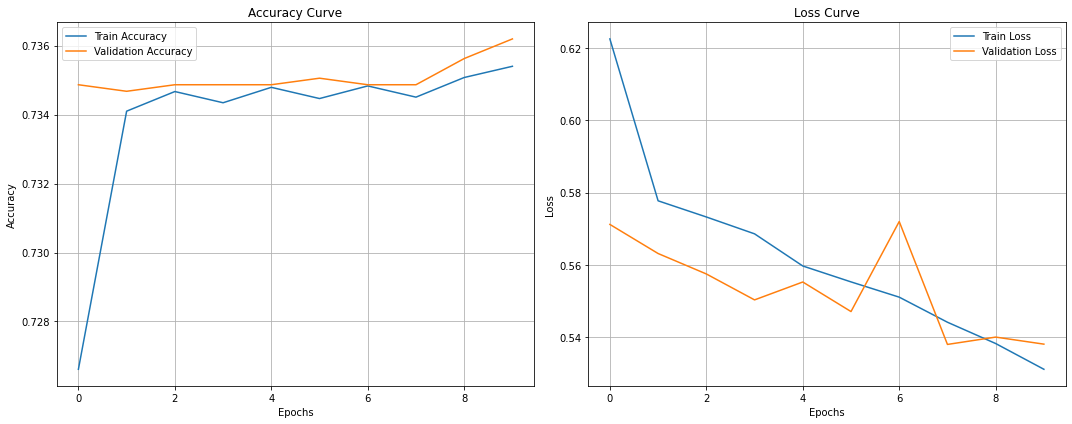

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, cohen_kappa_score
import numpy as np

# 取得測試集的真實標籤
true_labels = test_batches.classes

# 預測測試集
predictions = model.predict(test_batches, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# 表示畫布分成1行2列，兩張小圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy 曲線
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss 曲線
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

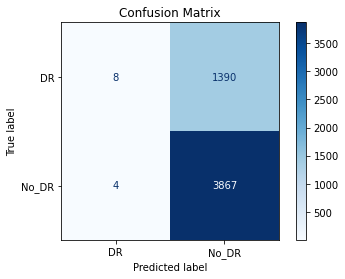

In [ ]:
# 混淆矩陣 (Confusion Matrix)
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Precision, Recall, F1-score, Kappa值整體指標
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Cohen\'s Kappa: {kappa:.2f}')

Precision: 0.74
Recall: 1.00
F1 Score: 0.85
Cohen's Kappa: 0.01


In [ ]:
# 各類別詳細分類報告
print("\nClassification Report:")
target_names = list(test_batches.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

          DR       0.67      0.01      0.01      1398
       No_DR       0.74      1.00      0.85      3871

    accuracy                           0.74      5269
   macro avg       0.70      0.50      0.43      5269
weighted avg       0.72      0.74      0.63      5269



In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

No DR


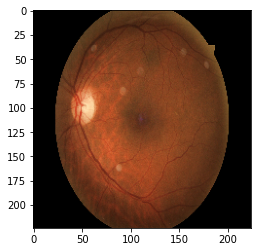

In [ ]:
predict_class('../input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images/No_DR/10042_left.png')